In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR

In [5]:

# Đọc dữ liệu từ các tập tin CSV hoặc bất kỳ nguồn dữ liệu nào khác
gold_data = pd.read_csv('GOLD.csv')
oil_data = pd.read_csv('OIL.csv')
dxy_data = pd.read_csv('DXY.csv')
spx_data = pd.read_csv('SPX.csv')
eurusd_data = pd.read_csv('EU.csv')

# Đặt lại cột ngày thành kiểu dữ liệu datetime với định dạng "ngày/tháng/năm"
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%d/%m/%Y')
oil_data['Date'] = pd.to_datetime(oil_data['Date'], format='%d/%m/%Y')
dxy_data['Date'] = pd.to_datetime(dxy_data['Date'], format='%d/%m/%Y')
spx_data['Date'] = pd.to_datetime(spx_data['Date'], format='%d/%m/%Y')
eurusd_data['Date'] = pd.to_datetime(eurusd_data['Date'], format='%d/%m/%Y')

# Merge các tập dữ liệu theo cột 'Date'
merged_data = pd.merge(gold_data, oil_data, on='Date', how='inner')
merged_data = pd.merge(merged_data, dxy_data, on='Date', how='inner')
merged_data = pd.merge(merged_data,eurusd_data,on='Date', how='inner')
df_final = pd.merge(merged_data, spx_data, on='Date', how='inner')
# df_final = merged_data[::-1]
# df_final = df_final.reset_index(drop=True)

for col in df_final.columns:
    if df_final[col].dtype == 'object':
        try:
            df_final[col] = df_final[col].str.replace(',', '').astype(float)
        except ValueError:
            pass  # Bỏ qua nếu không thể chuyển đổi


# Kết quả là một dataframe chỉ chứa các dòng có ngày giống nhau trong tất cả các tập dữ liệu
df_final


,Date,Close,Open,High,Low,Oil_Close,Oil_Open,Oil_High,Oil_Low,DXY_Close,...,DXY_High,DXY_Low,EURUSD_Close,EURUSD_Open,EURUSD_High,EURUSD_Low,SPX_Close,SPX_Open,SPX_High,SPX_Low
0,2024-05-01,2317.88,2285.91,2328.40,2281.66,79.44,81.72,81.92,79.17,105.71,...,106.49,105.44,1.0709,1.0664,1.0733,1.0649,5018.39,5029.03,5096.12,5013.45
1,2024-04-30,2284.57,2335.10,2336.54,2284.94,81.69,82.97,83.67,81.32,106.33,...,106.35,105.67,1.0665,1.0724,1.0736,1.0664,5035.69,5103.78,5110.83,5035.31
2,2024-04-29,2334.44,2337.50,2346.85,2320.08,82.98,83.61,84.31,82.77,105.70,...,106.08,105.46,1.0719,1.0695,1.0734,1.0690,5116.17,5114.13,5123.49,5088.65
3,2024-04-26,2337.72,2332.16,2352.62,2326.30,84.14,84.22,84.91,83.80,106.09,...,106.19,105.42,1.0692,1.0732,1.0754,1.0674,5099.96,5084.65,5114.62,5073.14
4,2024-04-25,2331.78,2316.20,2344.86,2305.28,84.20,83.11,84.29,82.46,105.60,...,106.00,105.53,1.0729,1.0699,1.0740,1.0678,5048.42,5019.88,5057.75,4990.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,2021-05-07,1830.48,1815.48,1843.45,1812.90,64.81,64.86,65.20,63.88,90.23,...,90.96,90.19,1.2163,1.2066,1.2172,1.2053,4232.60,4210.30,4238.00,4201.60
751,2021-05-06,1815.18,1787.09,1818.21,1781.67,64.88,65.06,65.94,64.51,90.95,...,91.38,90.88,1.2064,1.2005,1.2072,1.1992,4201.60,4169.10,4202.70,4147.30
752,2021-05-05,1786.44,1778.91,1788.35,1769.95,65.09,66.22,66.71,64.89,91.31,...,91.44,91.17,1.2005,1.2013,1.2027,1.1985,4167.60,4177.10,4187.70,4160.90
753,2021-05-04,1778.48,1792.29,1799.38,1770.84,66.20,64.58,66.25,64.25,91.29,...,91.40,90.99,1.2013,1.2064,1.2066,1.1998,4164.70,4179.00,4179.00,4128.60


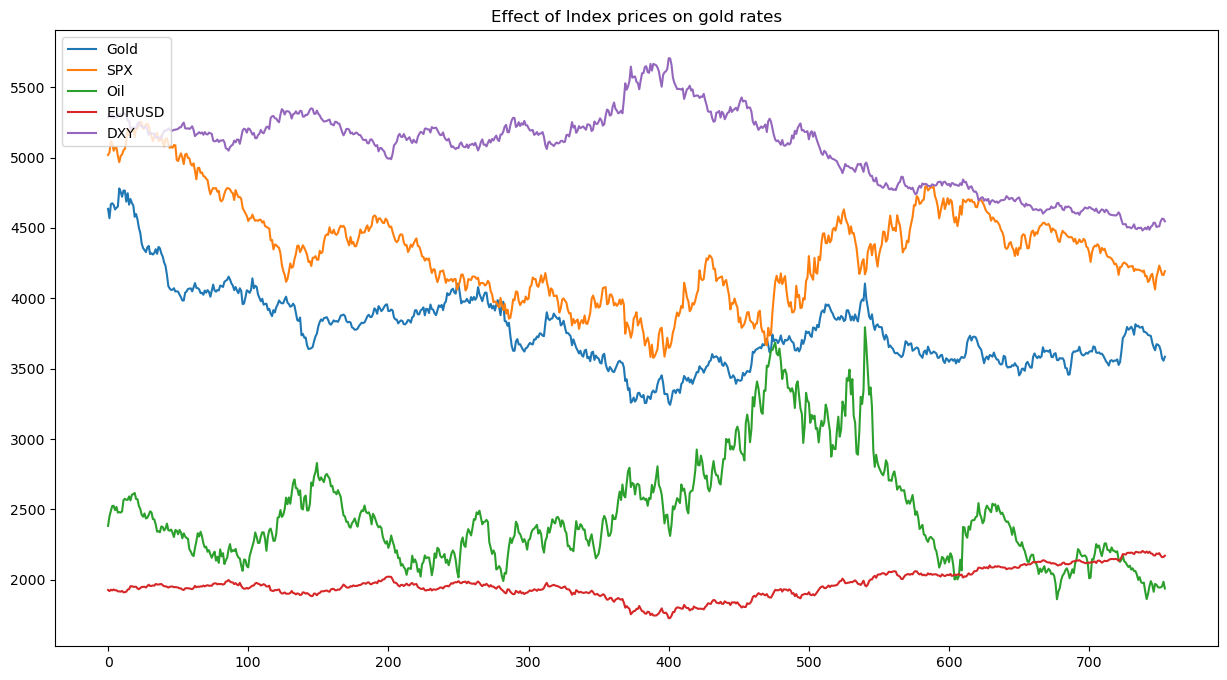

In [6]:
Gold_Close = 2 * df_final['Close']
SPX_Close = df_final['SPX_Close']
Oil_Close  = 30 * df_final['Oil_Close']
DXY_Close = 50 * df_final['DXY_Close']
EURUSD_Close = 1800 * df_final['EURUSD_Close']

df_p = pd.DataFrame({'Gold':Gold_Close, 'SPX':SPX_Close, 'Oil':Oil_Close, 'EURUSD':EURUSD_Close, 'DXY':DXY_Close})

df_ax = df_p.plot(title='Effect of Index prices on gold rates',figsize=(15,8))

df_ax.legend(loc='upper left')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_6844\1673293204.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_final.corr(), annot=True)


<Axes: >

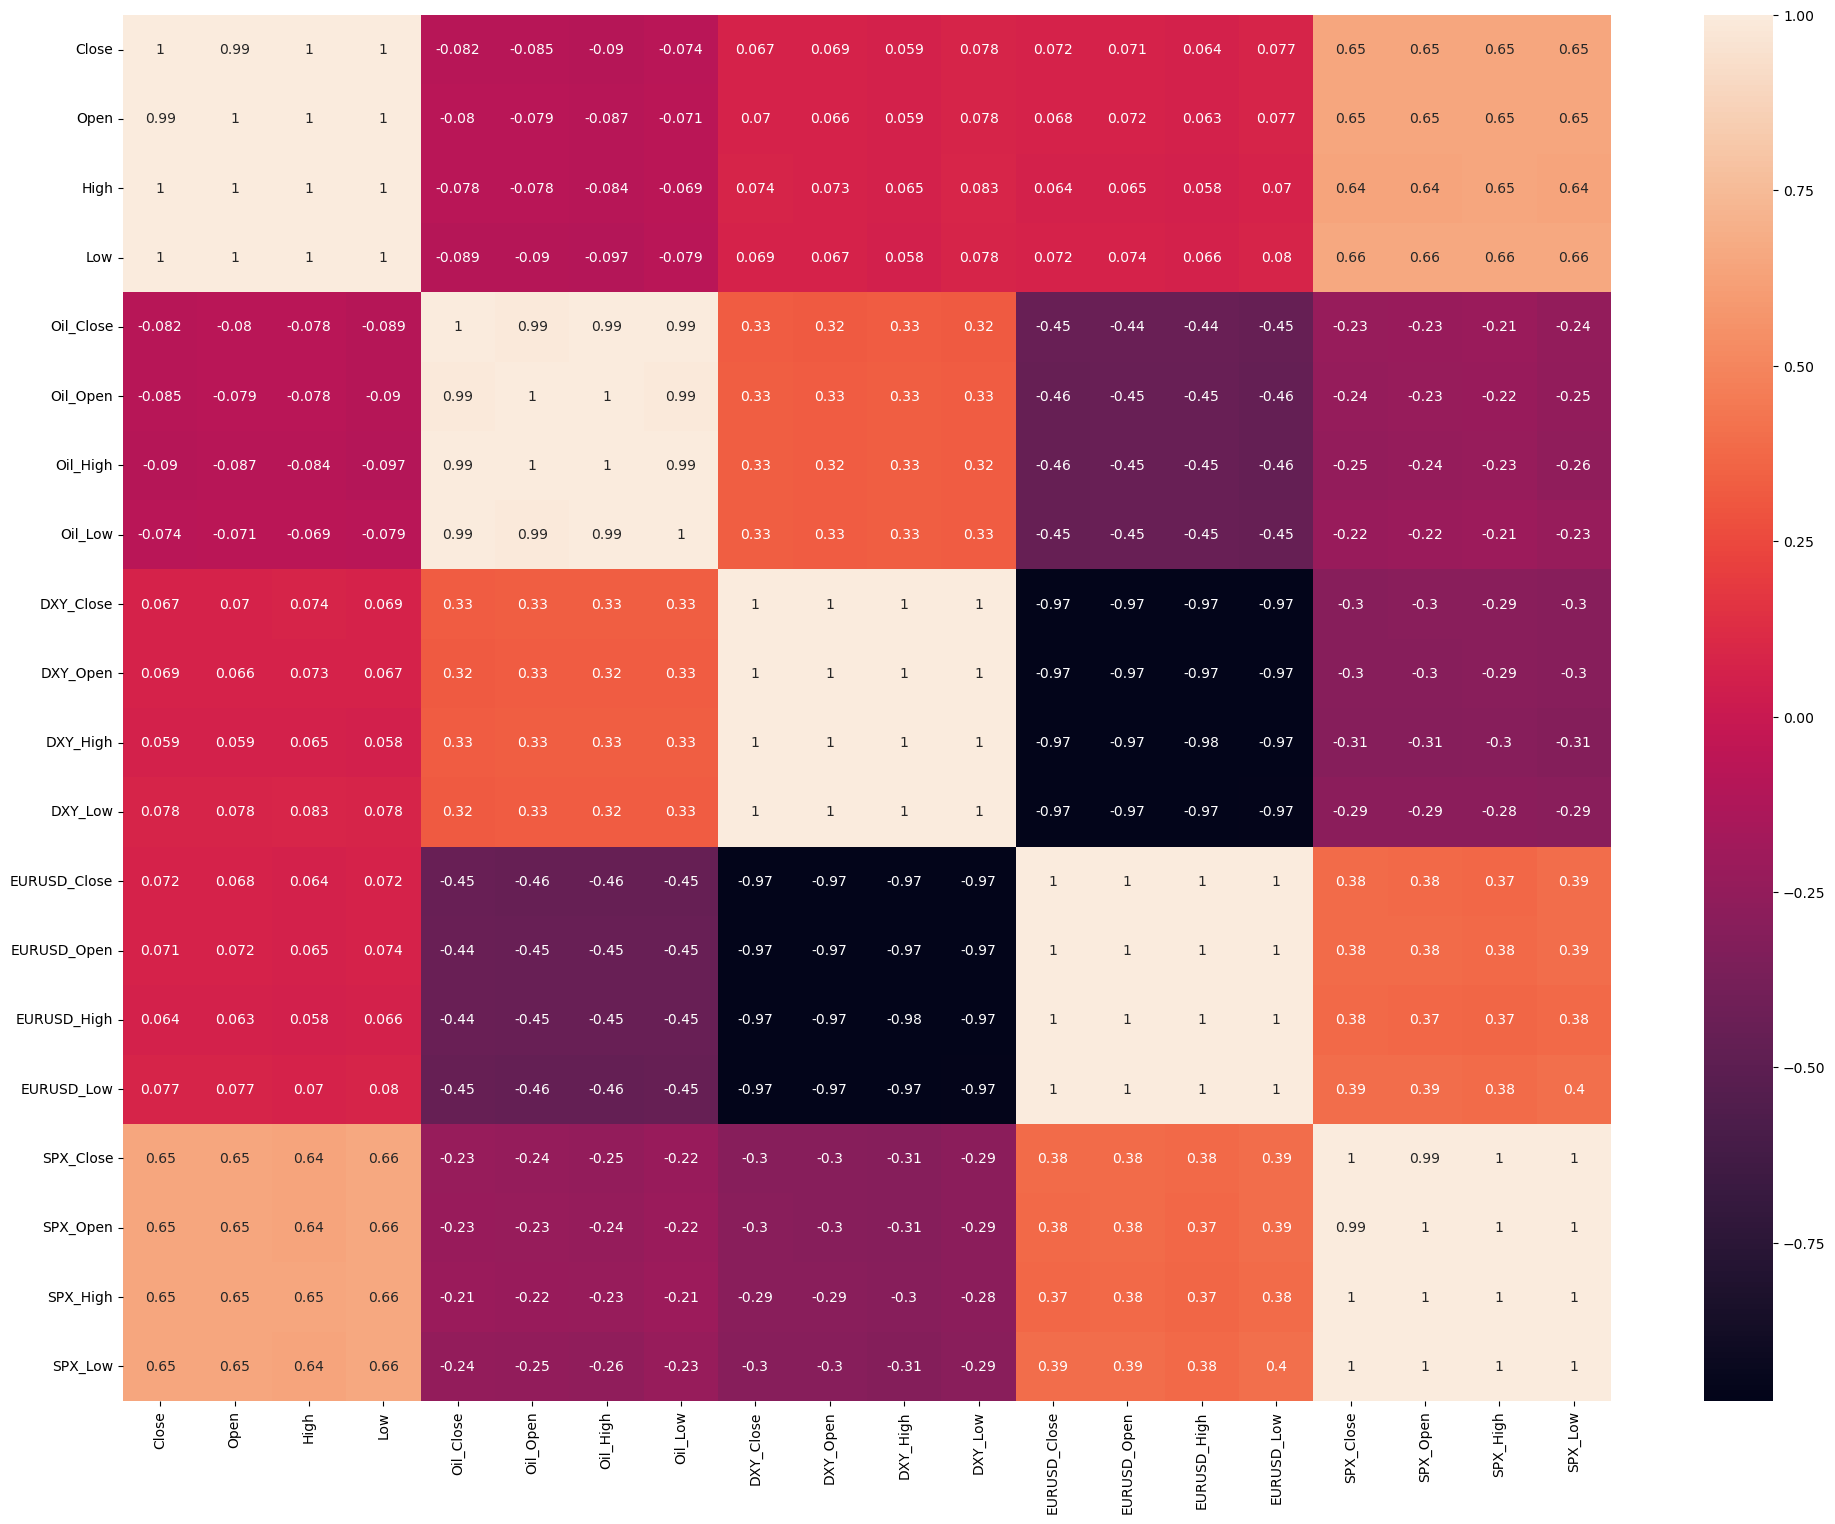

In [7]:
plt.figure(figsize=(24,18)) 
sns.heatmap(df_final.corr(), annot=True) 

In [8]:
corr_matrix=df_final.corr()
coef=corr_matrix["Close"].sort_values(ascending=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6844\3689924092.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=df_final.corr()


In [9]:
pos_corr=coef[coef>0]
pos_corr

Close           1.000000
Low             0.996888
High            0.996666
Open            0.992690
SPX_High        0.652348
SPX_Open        0.651583
SPX_Low         0.651203
SPX_Close       0.650788
DXY_Low         0.077789
EURUSD_Low      0.077328
EURUSD_Close    0.071763
EURUSD_Open     0.070780
DXY_Open        0.068573
DXY_Close       0.067472
EURUSD_High     0.063926
DXY_High        0.058730
Name: Close, dtype: float64

In [10]:
neg_corr=coef[coef<0]
neg_corr

Oil_Low     -0.073787
Oil_Close   -0.081686
Oil_Open    -0.084858
Oil_High    -0.090314
Name: Close, dtype: float64

In [11]:
def calculate_MACD(df, nslow=26, nfast=12):
    emaslow = df.ewm(span=nslow, min_periods=nslow, adjust=True, ignore_na=False).mean()
    emafast = df.ewm(span=nfast, min_periods=nfast, adjust=True, ignore_na=False).mean()
    dif = emafast - emaslow
    MACD = dif.ewm(span=9, min_periods=9, adjust=True, ignore_na=False).mean()
    return dif, MACD

def calculate_RSI(df, periods=14):
    # wilder's RSI
    delta = df.diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=periods,adjust=False).mean()
    rDown = down.ewm(com=periods, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)
    return rsi

def calculate_SMA(df, peroids=15):
    SMA = df.rolling(window=peroids, min_periods=peroids, center=False).mean()
    return SMA

def calculate_BB(df, peroids=15):
    STD = df.rolling(window=peroids,min_periods=peroids, center=False).std()
    SMA = calculate_SMA(df)
    upper_band = SMA + (2 * STD)
    lower_band = SMA - (2 * STD)
    return upper_band, lower_band

def calculate_stdev(df,periods=5):
    STDEV = df.rolling(periods).std()
    return STDEV

In [12]:
Gold_Close = df_final['Close']

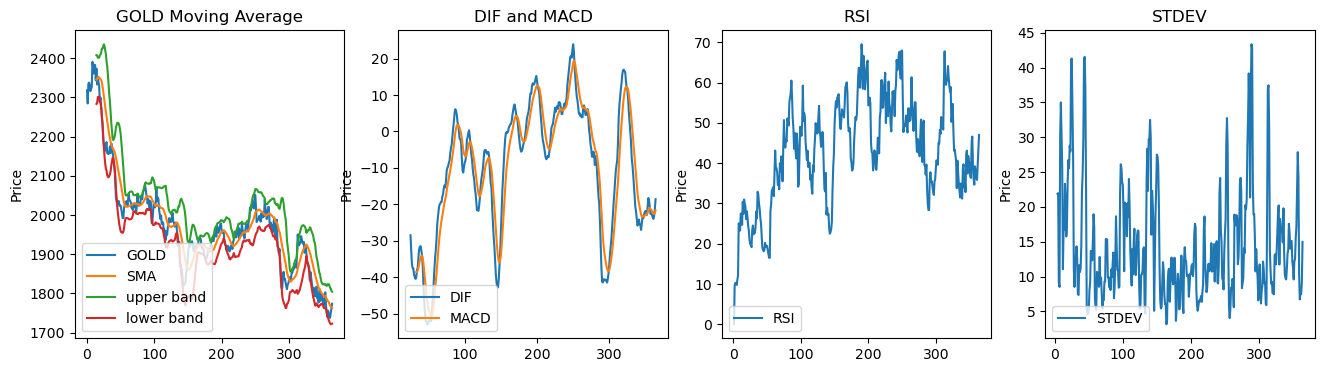

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Calculate Simple Moving Average for GLD
SMA_GLD = calculate_SMA(Gold_Close)

Gold_Close[:365].plot(title='GOLD Moving Average',label='GOLD', ax=axes[0])

SMA_GLD[:365].plot(label="SMA",ax=axes[0])


# Calculate Bollinger Bands for GLD
upper_band, lower_band = calculate_BB(Gold_Close)

upper_band[:365].plot(label='upper band', ax=axes[0])
lower_band[:365].plot(label='lower band', ax=axes[0])


# Calculate MACD for GLD
DIF, MACD = calculate_MACD(Gold_Close)

DIF[:365].plot(title='DIF and MACD',label='DIF', ax=axes[1])
MACD[:365].plot(label='MACD', ax=axes[1])

# Calculate RSI for GLD
RSI = calculate_RSI(Gold_Close)
RSI[:365].plot(title='RSI',label='RSI', ax=axes[2])

# Calculating Standard deviation for GLD
STDEV= calculate_stdev(Gold_Close)
STDEV[:365].plot(title='STDEV',label='STDEV', ax=axes[3])

Open_Close=df_final.Open - df_final.Close

High_Low=df_final.High-df_final.Low

axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')
axes[2].set_ylabel('Price')
axes[3].set_ylabel('Price')

axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')
axes[2].legend(loc='lower left')
axes[3].legend(loc='lower left')

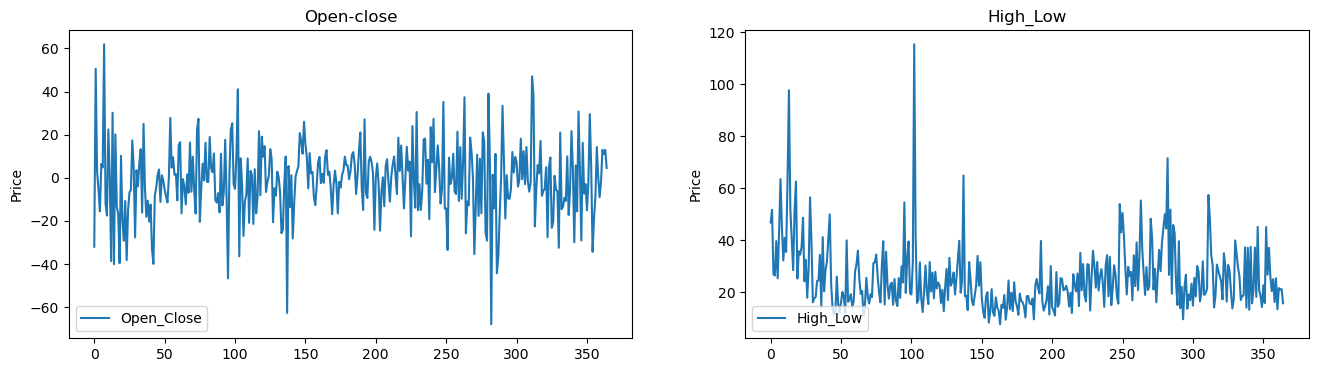

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
Open_Close=df_final.Open - df_final.Close
Open_Close[:365].plot(title='Open-close',label='Open_Close', ax=axes[0])

High_Low=df_final.High-df_final.Low
High_Low[:365].plot(title='High_Low',label='High_Low', ax=axes[1])
axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')




axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')


In [15]:
test = df_final
test['SMA'] = SMA_GLD
test['Upper_band'] = upper_band
test['Lower_band'] = lower_band
test['DIF'] = DIF
test['MACD'] = MACD
test['RSI'] = RSI
test['STDEV'] = STDEV
test['Open_Close']=Open_Close
test['High_Low']=High_Low


# Dropping first 33 records from the data as it has null values because of introduction of technical indicators
test = test[33:]

# Target column
target_adj_close = pd.DataFrame(test['Close'])


display(test.head())

,Date,Close,Open,High,Low,Oil_Close,Oil_Open,Oil_High,Oil_Low,DXY_Close,...,SPX_Low,SMA,Upper_band,Lower_band,DIF,MACD,RSI,STDEV,Open_Close,High_Low
33,2024-03-14,2161.01,2174.29,2177.10,2152.86,80.97,79.78,81.50,79.69,103.36,...,5123.3,2204.012000,2307.768363,2100.255637,-39.904863,-38.573771,24.231070,12.496517,13.28,24.24
34,2024-03-13,2174.40,2158.25,2179.91,2155.54,79.75,78.06,79.94,77.67,102.79,...,5151.9,2196.343333,2289.505786,2103.180881,-38.009040,-38.447239,28.025583,7.459808,-16.15,24.37
35,2024-03-12,2157.99,2183.00,2184.86,2150.59,78.06,78.17,78.77,77.42,102.96,...,5114.5,2186.931333,2262.422520,2111.440146,-37.322490,-38.201150,26.296357,7.354640,25.01,34.27
36,2024-03-11,2182.47,2177.71,2189.04,2174.80,78.16,77.88,78.54,76.87,102.87,...,5091.1,2180.422667,2235.585489,2125.259844,-34.506996,-37.407801,32.912497,11.617821,-4.76,14.24
37,2024-03-08,2177.51,2159.40,2195.20,2154.08,77.93,79.33,80.09,77.66,102.71,...,5117.5,2175.566000,2214.895104,2136.236896,-32.283391,-36.323297,32.283385,10.654064,-18.11,41.12


In [16]:
df_final.columns

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Oil_Close', 'Oil_Open',
       'Oil_High', 'Oil_Low', 'DXY_Close', 'DXY_Open', 'DXY_High', 'DXY_Low',
       'EURUSD_Close', 'EURUSD_Open', 'EURUSD_High', 'EURUSD_Low', 'SPX_Close',
       'SPX_Open', 'SPX_High', 'SPX_Low', 'SMA', 'Upper_band', 'Lower_band',
       'DIF', 'MACD', 'RSI', 'STDEV', 'Open_Close', 'High_Low'],
      dtype='object')

In [17]:
feature_columns = ['Open', 'High', 'Low', 'Oil_Close', 'Oil_Open',
       'Oil_High', 'Oil_Low', 'DXY_Close', 'DXY_Open', 'DXY_High', 'DXY_Low',
       'EURUSD_Close', 'EURUSD_Open', 'EURUSD_High', 'EURUSD_Low', 'SPX_Close',
       'SPX_Open', 'SPX_High', 'SPX_Low', 'SMA', 'Upper_band', 'Lower_band',
       'DIF', 'MACD', 'RSI', 'STDEV', 'Open_Close', 'High_Low']

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Oil_Close,Oil_Open,Oil_High,Oil_Low,DXY_Close,DXY_Open,DXY_High,...,SPX_Low,SMA,Upper_band,Lower_band,DIF,MACD,RSI,STDEV,Open_Close,High_Low
33,0.984474,0.967321,0.960853,0.293588,0.268019,0.263608,0.302233,0.560687,0.533687,0.543155,...,0.982774,1.000000,1.000000,0.918615,0.149043,0.149822,0.132212,0.214777,0.628609,0.154724
34,0.955883,0.972395,0.965635,0.274647,0.241975,0.240216,0.268577,0.537393,0.540629,0.527900,...,1.000000,0.986288,0.971406,0.923797,0.170756,0.151406,0.197014,0.112921,0.400805,0.155931
35,1.000000,0.981332,0.956803,0.248409,0.243640,0.222672,0.264412,0.544340,0.536137,0.534324,...,0.977474,0.969458,0.929001,0.938426,0.178620,0.154488,0.167482,0.110794,0.719406,0.247819
36,0.990571,0.988878,1.000000,0.249961,0.239249,0.219223,0.255248,0.540662,0.532871,0.524287,...,0.963380,0.957820,0.886981,0.962904,0.210866,0.164421,0.280472,0.197007,0.488970,0.061908
37,0.957933,1.000000,0.963030,0.246390,0.261205,0.242465,0.268411,0.534123,0.532462,0.523083,...,0.979281,0.949136,0.854586,0.982347,0.236334,0.177999,0.269728,0.177517,0.385634,0.311398


In [19]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,Open,High,Low,Oil_Close,Oil_Open,Oil_High,Oil_Low,DXY_Close,DXY_Open,DXY_High,...,SPX_Low,SMA,Upper_band,Lower_band,DIF,MACD,RSI,STDEV,Open_Close,High_Low
33,0.984474,0.967321,0.960853,0.293588,0.268019,0.263608,0.302233,0.560687,0.533687,0.543155,...,0.982774,1.000000,1.000000,0.918615,0.149043,0.149822,0.132212,0.214777,0.628609,0.154724
34,0.955883,0.972395,0.965635,0.274647,0.241975,0.240216,0.268577,0.537393,0.540629,0.527900,...,1.000000,0.986288,0.971406,0.923797,0.170756,0.151406,0.197014,0.112921,0.400805,0.155931
35,1.000000,0.981332,0.956803,0.248409,0.243640,0.222672,0.264412,0.544340,0.536137,0.534324,...,0.977474,0.969458,0.929001,0.938426,0.178620,0.154488,0.167482,0.110794,0.719406,0.247819
36,0.990571,0.988878,1.000000,0.249961,0.239249,0.219223,0.255248,0.540662,0.532871,0.524287,...,0.963380,0.957820,0.886981,0.962904,0.210866,0.164421,0.280472,0.197007,0.488970,0.061908
37,0.957933,1.000000,0.963030,0.246390,0.261205,0.242465,0.268411,0.534123,0.532462,0.523083,...,0.979281,0.949136,0.854586,0.982347,0.236334,0.177999,0.269728,0.177517,0.385634,0.311398


Shape of features :  (722, 28)
Shape of target :  (722, 1)


,Open,High,Low,Oil_Close,Oil_Open,Oil_High,Oil_Low,DXY_Close,DXY_Open,DXY_High,...,SPX_Low,SMA,Upper_band,Lower_band,DIF,MACD,RSI,STDEV,Open_Close,High_Low
749,0.376553,0.368690,0.384941,0.044869,0.050878,0.026991,0.039653,0.023294,0.022050,0.018868,...,0.419502,0.395962,0.397586,0.403405,0.575773,0.717686,0.471983,0.174511,0.508786,0.073046
750,0.344896,0.364935,0.354269,0.042695,0.042096,0.019193,0.038820,0.024111,0.048591,0.043758,...,0.427634,0.387360,0.388468,0.396679,0.559078,0.690427,0.447156,0.136167,0.409707,0.213291
751,0.294291,0.319365,0.298546,0.043782,0.045124,0.030289,0.049317,0.053535,0.064516,0.060618,...,0.394929,0.377716,0.381986,0.384905,0.532555,0.662822,0.375597,0.177753,0.308383,0.268888
752,0.279710,0.265455,0.277634,0.047042,0.062689,0.041835,0.055648,0.068247,0.064924,0.063027,...,0.403120,0.364603,0.379447,0.361800,0.486354,0.630636,0.267151,0.388743,0.467528,0.100520
753,0.303560,0.285369,0.279222,0.064276,0.037856,0.034938,0.044985,0.067430,0.053491,0.061421,...,0.383666,0.350206,0.371683,0.342059,0.444249,0.595682,0.241534,0.481483,0.632712,0.194635


,Close
749,1830.48
750,1815.18
751,1786.44
752,1778.48
753,1792.36



 -----After process------ 

Shape of features :  (632, 28)
Shape of target :  (632, 1)


,Close
660,1804.27
661,1793.49
662,1787.34
663,1794.69
664,1788.93


In [20]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()
       

In [21]:
X_train.shape

(575, 28)

In [22]:
X_test.shape

(57, 28)

In [23]:
y_train.shape

(575,)

In [24]:
y_test.shape

(57,)

In [25]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

Model building

RMSE:  2.894955511874123
R2 score:  0.9955254546459394


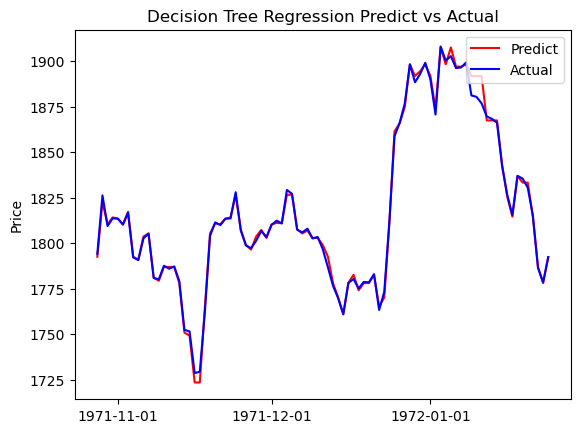

In [26]:

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)

benchmark_dt=dt.fit(X_train, y_train)

validate_result(benchmark_dt, 'Decision Tree Regression')

RMSE:  63.87833072820403
R2 score:  -1.178573634691117


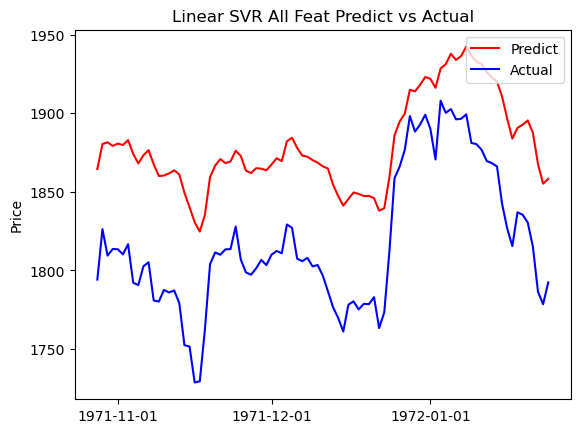

In [27]:
# Save all soultion models
solution_models = {}
# SVR with  linear Kernel
svr_lin = SVR(kernel='linear')
linear_svr_clf_feat = svr_lin.fit(X_train,y_train)
validate_result(linear_svr_clf_feat,'Linear SVR All Feat')

RMSE:  3.300368033842092
R2 score:  0.9941844623685068


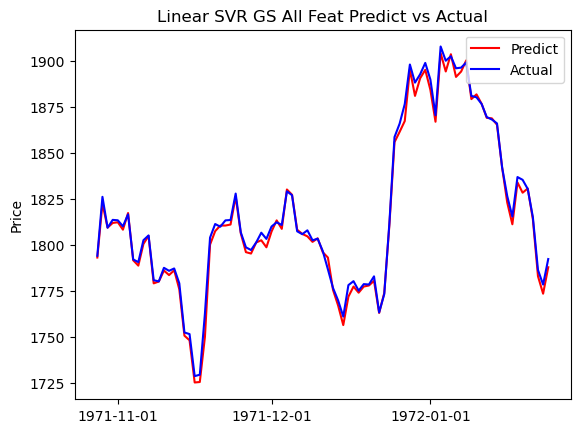

In [28]:
linear_svr_parameters = {
    'C':[0.5, 1.0, 10.0, 50.0],
    'epsilon':[0, 0.1, 0.5, 0.7, 0.9],
}

lsvr_grid_search_feat = GridSearchCV(estimator=linear_svr_clf_feat,
                           param_grid=linear_svr_parameters,
                           cv=ts_split,
)

lsvr_grid_search_feat.fit(X_train, y_train)

validate_result(lsvr_grid_search_feat,'Linear SVR GS All Feat')

In [29]:
solution_models['SVR All Feat'] = lsvr_grid_search_feat

RMSE:  1.4160222739948554
R2 score:  0.9989294540916476


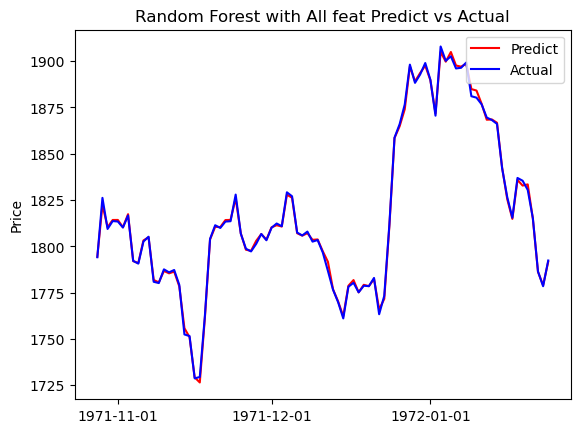

In [30]:

rf_cl = RandomForestRegressor(n_estimators=50, random_state=0)
random_forest_clf_feat = rf_cl.fit(X_train,y_train)
validate_result(random_forest_clf_feat,'Random Forest with All feat')

RMSE:  1.4160222739948554
R2 score:  0.9989294540916476


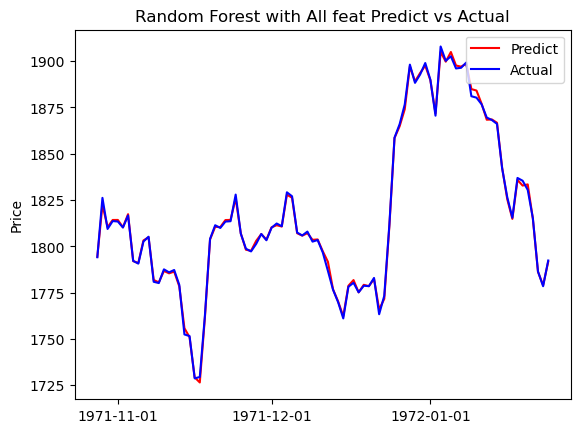

In [31]:

rf_cl = RandomForestRegressor(n_estimators=50, random_state=0)
random_forest_clf_feat = rf_cl.fit(X_train,y_train)
validate_result(random_forest_clf_feat,'Random Forest with All feat')

In [32]:
random_forest_parameters = {
    'n_estimators':[10,15,20, 50, 100],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[2, 3, 5, 7,10],
}

grid_search_RF_feat = GridSearchCV(estimator=random_forest_clf_feat,
                           param_grid=random_forest_parameters,
                           cv=ts_split,
)

grid_search_RF_feat.fit(X_train, y_train)

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Admin\anaconda3\Lib\site-packag

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(n_estimators=50, random_state=0),
             param_grid={'max_depth': [2, 3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 15, 20, 50, 100]})

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 50}
RMSE:  11.9860947179608
R2 score:  0.9232955541280486


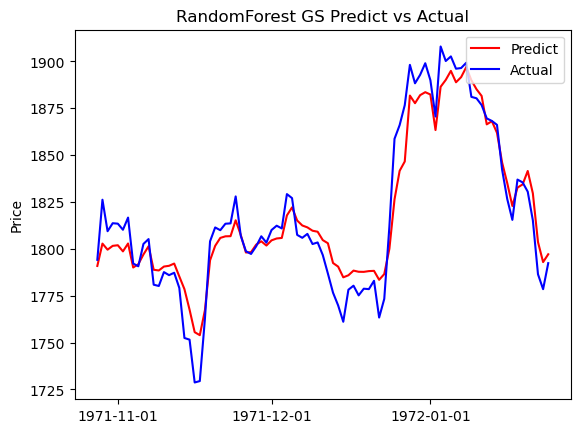

In [33]:
print(grid_search_RF_feat.best_params_)
validate_result(grid_search_RF_feat,'RandomForest GS')

In [34]:
solution_models['Random_Forest with Feat'] = random_forest_clf_feat

RMSE:  0.9728112468808069
R2 score:  0.9994947314205682


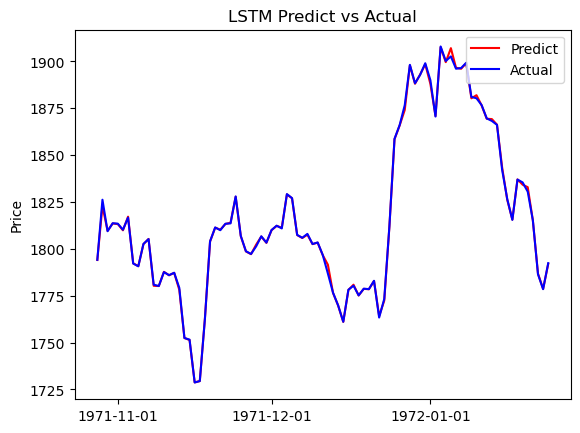

RMSE:  4.176842583069155
R2 score:  0.9906854615029876


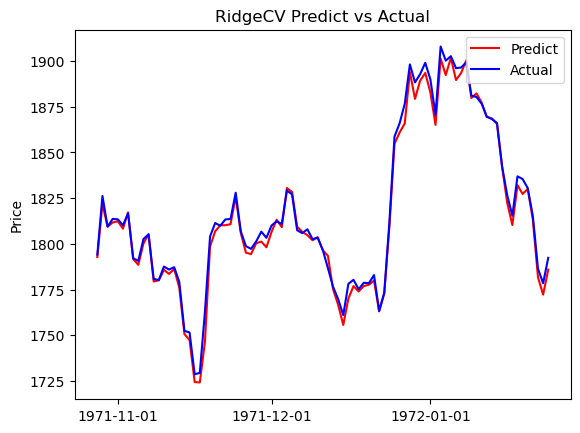

In [44]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

lasso_clf = LassoCV(n_alphas=1000, max_iter=3000, random_state=0)
ridge_clf = RidgeCV(gcv_mode='auto')

lasso_clf_feat = lasso_clf.fit(X_train,y_train)
validate_result(lasso_clf_feat,'LSTM')
solution_models['LSTM'] = lasso_clf_feat

ridge_clf_feat = ridge_clf.fit(X_train,y_train)
validate_result(ridge_clf_feat,'RidgeCV')
solution_models['RidgeCV All Feat'] = ridge_clf_feat

RMSE:  1.200709755930334
R2 score:  0.999230265052333


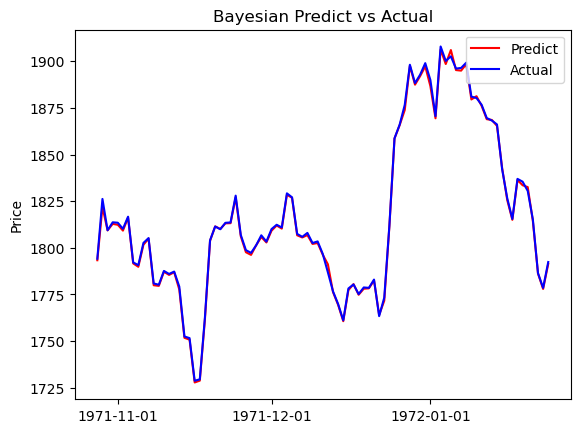

In [45]:

from sklearn import linear_model
bay = linear_model.BayesianRidge()
bay_feat = bay.fit(X_train,y_train)
validate_result(bay_feat,'Bayesian')
solution_models['Bay All Feat'] = bay_feat

RMSE:  1.8255626515028376
R2 score:  0.9982206613580872


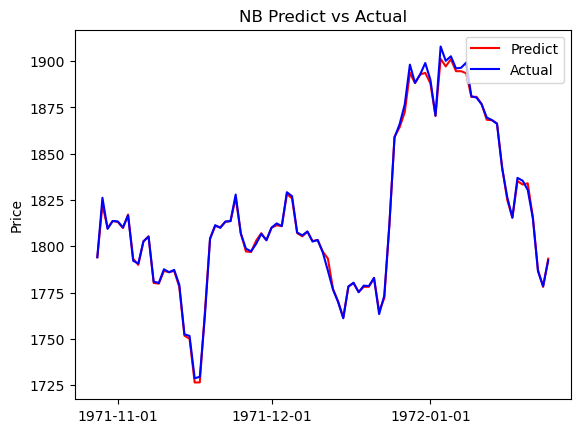

In [46]:

from sklearn.ensemble import GradientBoostingRegressor
regr =GradientBoostingRegressor(n_estimators=70, learning_rate=0.1,max_depth=4, random_state=0, loss='squared_error')
GB_feat = regr.fit(X_train,y_train)
validate_result(GB_feat,'NB')
solution_models['GB All Feat'] = GB_feat

RMSE:  69.28842549333565
R2 score:  -1.5632237081018525


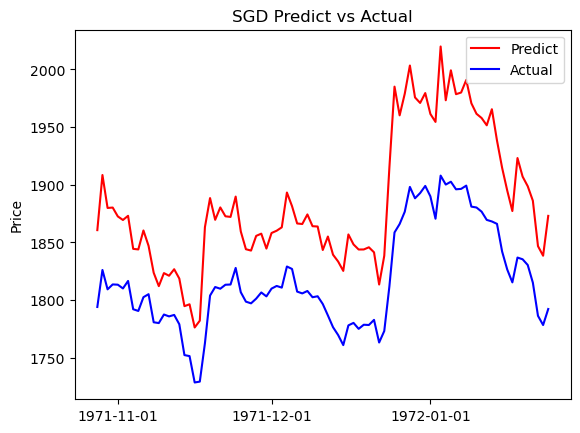

In [47]:
from sklearn.linear_model import SGDRegressor
sgd =SGDRegressor(max_iter=1000, tol=1e-3,loss='squared_epsilon_insensitive',penalty='l1',alpha=0.1)
sgd_feat = sgd.fit(X_train,y_train)
validate_result(sgd_feat,'SGD')
solution_models['SGD All Feat'] = sgd_feat

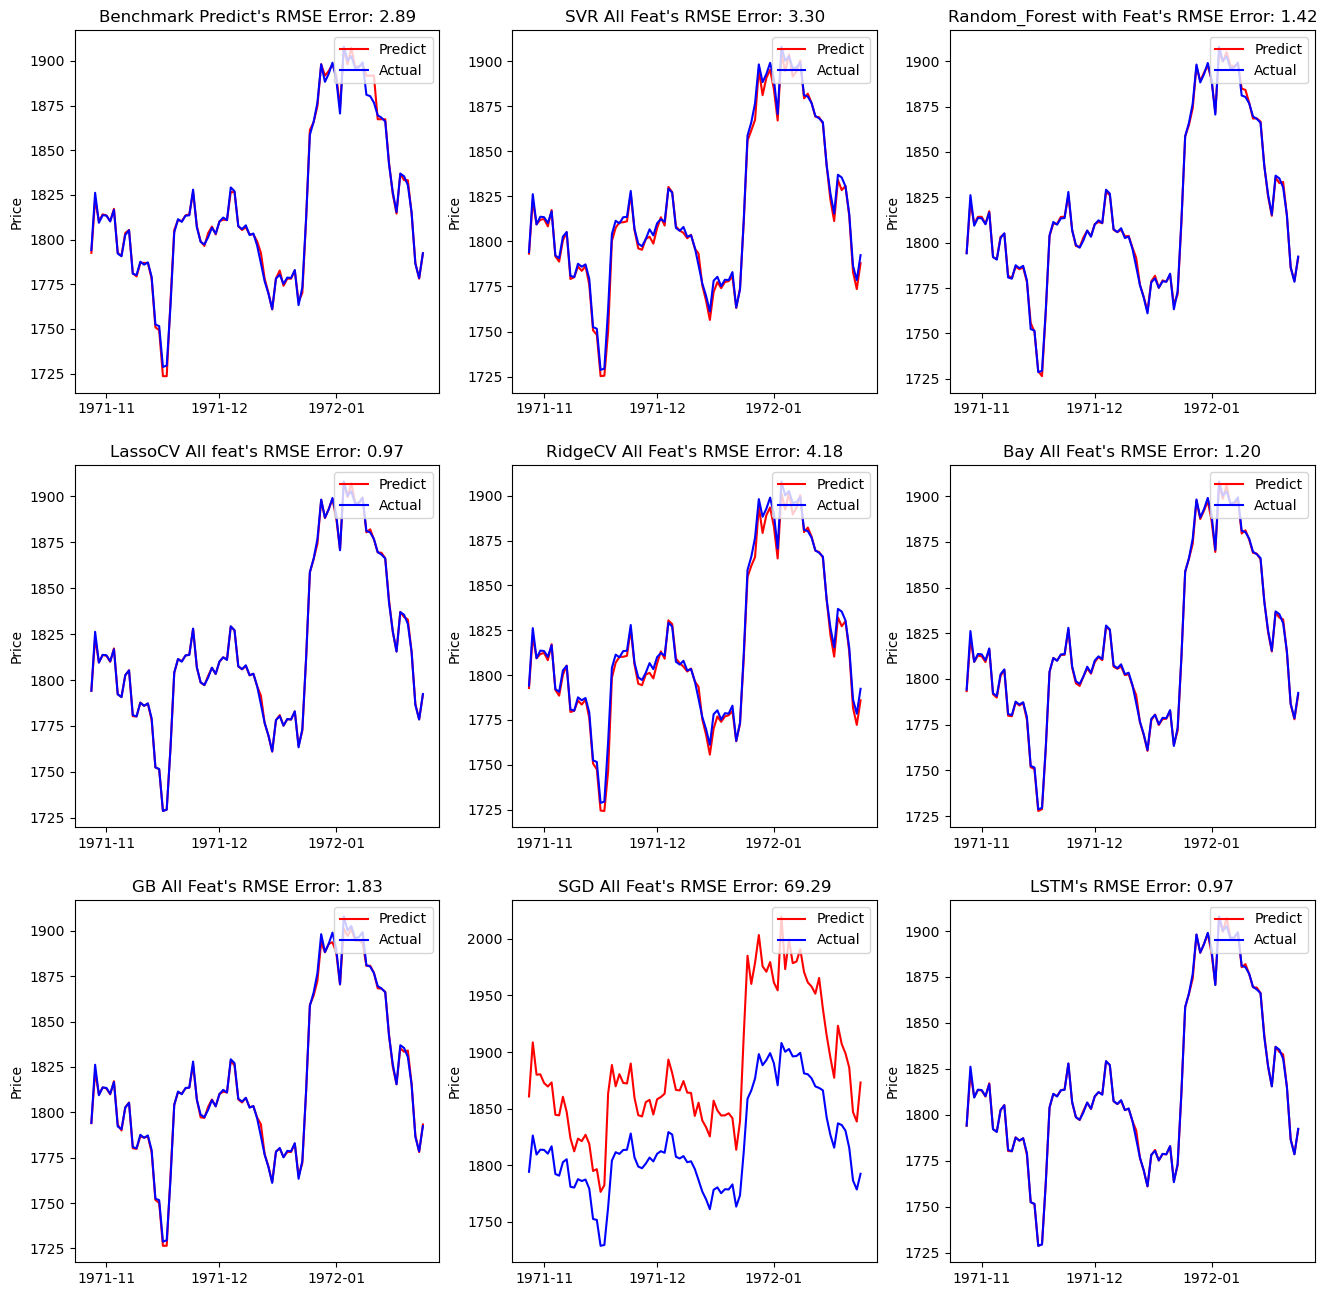

In [48]:
RMSE_scores = {}
def model_review(models):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))

    #plot benchmark model
    benchmark_predicted = benchmark_dt.predict(validation_X)
    benchmark_RSME_score = np.sqrt(mean_squared_error(validation_y, benchmark_predicted))
    RMSE_scores['Benchmark'] = benchmark_RSME_score
    
    axes[0,0].plot(validation_y.index, benchmark_predicted,'r', label='Predict')
    axes[0,0].plot(validation_y.index, validation_y,'b', label='Actual')
    axes[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[0,0].xaxis.set_major_locator(mdates.MonthLocator())
    axes[0,0].set_ylabel('Price')
    axes[0,0].set_title("Benchmark Predict's RMSE Error: " +"{0:.2f}".format(benchmark_RSME_score))
    axes[0,0].legend(loc='upper right')
    
    #plot block
    ax_x = 0
    ax_y = 1
    #plot solution model
    for name, model in models.items():
        predicted = model.predict(validation_X)
        RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))

           
        axes[ax_x][ax_y].plot(validation_y.index, predicted,'r', label='Predict')
        axes[ax_x][ax_y].plot(validation_y.index, validation_y,'b', label='Actual')
        axes[ax_x][ax_y].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        axes[ax_x][ax_y].xaxis.set_major_locator(mdates.MonthLocator())
        axes[ax_x][ax_y].set_ylabel('Price')
        axes[ax_x][ax_y].set_title(name + "'s RMSE Error: " +"{0:.2f}".format(RSME_score))
        axes[ax_x][ax_y].legend(loc='upper right')
        RMSE_scores[name] = RSME_score
        if ax_x <=2:
            if ax_y < 2:
                ax_y += 1
            else:
                ax_x += 1
                ax_y = 0
    plt.show()

model_review(solution_models)

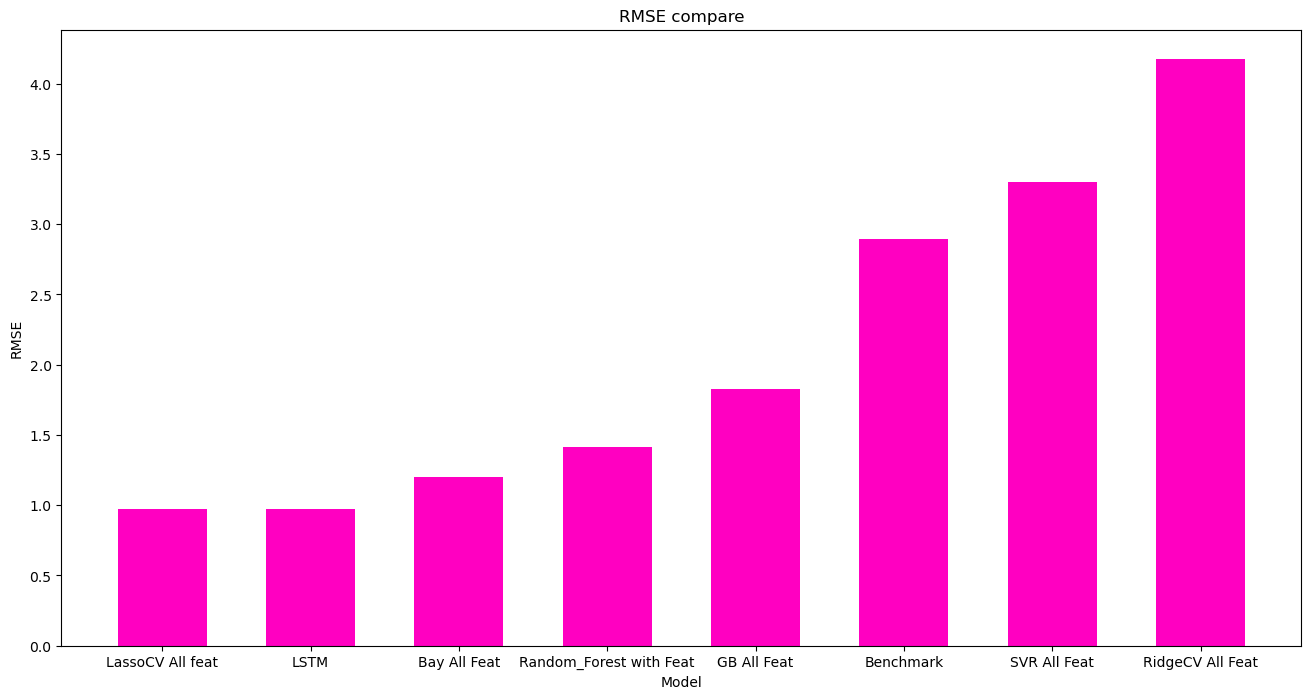

In [49]:
model_names = []
model_values = []
for name, value in RMSE_scores.items():
    model_names.append(name)
    model_values.append(value)

model_values = np.array(model_values)
model_names = np.array(model_names)

indices = np.argsort(model_values)
columns = model_names[indices[:8]]
values = model_values[indices][:8]

fig = plt.figure(figsize = (16,8))
plt.bar(np.arange(8), values ,width = 0.6, align="center", color = '#ff00c1')
plt.xticks(np.arange(8), columns)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE compare')   
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(lasso_clf_feat)
sfm.fit(feature_minmax_transform, target_adj_close.values.ravel())
display(feature_minmax_transform.head())
sup = sfm.get_support()
zipped = zip(feature_minmax_transform,sup)
print(*zipped)

,Open,High,Low,Oil_Close,Oil_Open,Oil_High,Oil_Low,DXY_Close,DXY_Open,DXY_High,...,SPX_Low,SMA,Upper_band,Lower_band,DIF,MACD,RSI,STDEV,Open_Close,High_Low
33,0.984474,0.967321,0.960853,0.293588,0.268019,0.263608,0.302233,0.560687,0.533687,0.543155,...,0.982774,1.000000,1.000000,0.918615,0.149043,0.149822,0.132212,0.214777,0.628609,0.154724
34,0.955883,0.972395,0.965635,0.274647,0.241975,0.240216,0.268577,0.537393,0.540629,0.527900,...,1.000000,0.986288,0.971406,0.923797,0.170756,0.151406,0.197014,0.112921,0.400805,0.155931
35,1.000000,0.981332,0.956803,0.248409,0.243640,0.222672,0.264412,0.544340,0.536137,0.534324,...,0.977474,0.969458,0.929001,0.938426,0.178620,0.154488,0.167482,0.110794,0.719406,0.247819
36,0.990571,0.988878,1.000000,0.249961,0.239249,0.219223,0.255248,0.540662,0.532871,0.524287,...,0.963380,0.957820,0.886981,0.962904,0.210866,0.164421,0.280472,0.197007,0.488970,0.061908
37,0.957933,1.000000,0.963030,0.246390,0.261205,0.242465,0.268411,0.534123,0.532462,0.523083,...,0.979281,0.949136,0.854586,0.982347,0.236334,0.177999,0.269728,0.177517,0.385634,0.311398


('Open', True) ('High', True) ('Low', True) ('Oil_Close', False) ('Oil_Open', True) ('Oil_High', False) ('Oil_Low', False) ('DXY_Close', False) ('DXY_Open', False) ('DXY_High', False) ('DXY_Low', False) ('EURUSD_Close', False) ('EURUSD_Open', False) ('EURUSD_High', False) ('EURUSD_Low', False) ('SPX_Close', False) ('SPX_Open', False) ('SPX_High', False) ('SPX_Low', False) ('SMA', False) ('Upper_band', False) ('Lower_band', True) ('DIF', False) ('MACD', False) ('RSI', False) ('STDEV', False) ('Open_Close', False) ('High_Low', False)


In [50]:
# Choosing the top three performing models to ensemble them
ensemble_solution_models = [lasso_clf_feat, bay_feat, ridge_clf_feat]
class EnsembleSolution:
    models = []
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        for i in self.models:
            i.fit(X, y)
    def predict(self, X):
        result = 0
        for i in self.models:
            result = result + i.predict(X)
        
        result = result / len(self.models)
        
        return result

Ensemble Solution Model with Original features
RMSE:  1.8509320774817284
R2 score:  0.9981708636087651


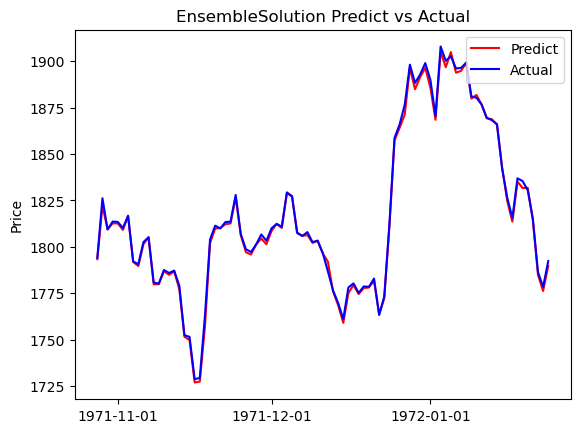

In [51]:
print("Ensemble Solution Model with Original features")
EnsembleModel = EnsembleSolution(ensemble_solution_models)
validate_result(EnsembleModel,'EnsembleSolution')

In [52]:
def train_reg_multipletimes(model, times):
    total_rmse = 0
    total_r2 = 0
    for i in range(times):
        reg = model
        for train_index, test_index in TimeSeriesSplit(n_splits=i+2).split(feature_minmax_transform):
            X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
            y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()
            reg.fit(X_train, y_train)
        predicted = reg.predict(validation_X)
        rmse, r2 = print_result(validation_y, predicted, [0,len(validation_y)])
        total_rmse += rmse
        total_r2 += r2
    return total_rmse / times, total_r2 / times

def print_result(actual, predict, index):
    RMSE_score = np.sqrt(mean_squared_error(actual, predict))
    print('From {} to {}'.format(index[0],index[-1]))
    print('RMSE: ', RMSE_score)
    R2_score = r2_score(actual, predict)
    print('R2 score: ', R2_score)
    print('---------------------')
    return RMSE_score, R2_score

In [ ]:
print('Benchmark')
t_multiple_benchmark_RMSE,t_multiple_benchmark_R2 = train_reg_multipletimes(benchmark_dt, 7)
print('RMSE: {} //  R2: {}\n'.format(t_multiple_benchmark_RMSE, t_multiple_benchmark_R2))

Benchmark
From 0 to 89
RMSE:  5.879625169586203
R2 score:  0.9815428599764644
---------------------
From 0 to 89
RMSE:  3.4981030172224843
R2 score:  0.993466734366354
---------------------
From 0 to 89
RMSE:  2.44015379879995
R2 score:  0.9968209341315531
---------------------
From 0 to 89
RMSE:  2.7806512453586363
R2 score:  0.9958718243228347
---------------------
From 0 to 89
RMSE:  3.190226648283124
R2 score:  0.9945661430257311
---------------------
From 0 to 89
RMSE:  2.257843258460459
R2 score:  0.9972782219630546
---------------------
From 0 to 89
RMSE:  3.1639521580496464
R2 score:  0.9946552801988264
---------------------
RMSE: 3.315793613680072 //  R2: 0.9934574282835456



In [ ]:
print('LSVR')
t_multiple_LSVR_RMSE,t_multiple_LSVR_R2 = train_reg_multipletimes(linear_svr_clf_feat, 7)
print(' RMSE: {} //  R2: {}'.format(t_multiple_LSVR_RMSE, t_multiple_LSVR_R2))

LSVR
From 0 to 89
RMSE:  125.9494883303705
R2 score:  -7.469503294130353
---------------------
From 0 to 89
RMSE:  126.82465894004834
R2 score:  -7.587614337174218
---------------------
From 0 to 89
RMSE:  122.60110295410793
R2 score:  -7.025163342524088
---------------------
From 0 to 89
RMSE:  109.62711209132121
R2 score:  -5.4165424754602345
---------------------
From 0 to 89
RMSE:  96.05423875103384
R2 score:  -3.9260429622730495
---------------------
From 0 to 89
RMSE:  85.69891117547502
R2 score:  -2.9211705709876084
---------------------
From 0 to 89
RMSE:  76.47474750598825
R2 score:  -2.1224912479727807
---------------------
 RMSE: 106.17575139262074 //  R2: -5.209789747217476


In [ ]:
print('Lasso')
t_multiple_lasso_RMSE,t_multiple_lasso_R2 = train_reg_multipletimes(lasso_clf_feat, 7)
print(' RMSE: {} //  R2: {}'.format(t_multiple_lasso_RMSE, t_multiple_lasso_R2))

Lasso
From 0 to 89
RMSE:  0.9686454700438245
R2 score:  0.9994990494822309
---------------------
From 0 to 89
RMSE:  0.9790091852348111
R2 score:  0.9994882726145903
---------------------
From 0 to 89
RMSE:  0.9773069214760216
R2 score:  0.9994900506115332
---------------------
From 0 to 89
RMSE:  0.972759341630813
R2 score:  0.999494785337281
---------------------
From 0 to 89
RMSE:  0.9734550627695997
R2 score:  0.9994940624160025
---------------------
From 0 to 89
RMSE:  0.9734865052641097
R2 score:  0.9994940297320148
---------------------
From 0 to 89
RMSE:  0.9730722215923697
R2 score:  0.9994944602888158
---------------------
 RMSE: 0.973962101144507 //  R2: 0.9994935300689239
